In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd
import polars as pl
from tqdm import tqdm 
import time

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/atmospred/pytorch/trained.pth/1/20240502-001.pth
/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv
/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv


# Timer for code running

Compute the time cost of a block

In [5]:
import time

class Timer:
    def __init__(self):
        self.t0 = 0
        self.t1 = 0
        self.times = []
        self.infos = []
        
    def start(self, info = 'Run'):
        self.t1 = self.t0
        self.infos.append(f'{len(self.infos)} {info}')
        self.t0 = time.time()
        
    def stop(self):
        self.t1 = time.time()
        t = self.t1 - self.t0
        self.times.append(t)
        print(f'{self.infos[-1]} Time Cost: {t:.3f}s')
        
    def get_stats(self):
        for info, tm in zip(self.infos, self.times):
            print(f'{info}\t{tm:.3f}s')
        print(f'Total: {sum(self.times):.3f}')
    
    def clear(self, idx=0):
        if idx == 0:
            self.infos.clear()
            self.times.clear()
            return
        info = self.infos.pop(idx - (0 if idx < 0 else 1))
        tm = self.times.pop(idx - (0 if idx < 0 else 1))
        return info, tm
        
timer = Timer()

# File Paths and Chunk Size

- set file path for train set and test set
- read training dataset with chunks as its large file

In [6]:
# 文件路径
train_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/train.csv'
test_csv = '/kaggle/input/leap-atmospheric-physics-ai-climsim/test.csv'
subm_spl = '/kaggle/input/leap-atmospheric-physics-ai-climsim/sample_submission.csv'
out_csv = 'submission.csv'

read_chunk_size = 50000 # 一次性读取50000行数据

- read data from csv file and get the 1st chunk

In [ ]:
# 读取数据
timer.start()
train_chunks = pd.read_csv(train_csv, chunksize = read_chunk_size)
train_data = next(train_chunks)
timer.stop()
# train_data = next(train_chunks)
# train_data = next(train_chunks)
cols = train_data.columns

train_data.shape

# Split training set

1. split into input and output
2. split into 
    - training set
    - validation set
    - testing set

In [7]:
# 划分数据集

def split_io(dframe, in_cols = cols[1:557], out_cols = cols[557:]):
    # 划分输入输出
    in_df = dframe[in_cols]
    out_df = dframe[out_cols]
    return in_df, out_df

def split_tvt(dframe, ratio=[0.8], shuffle=False):
    # 设定好 train (和 val) 集的比例，剩余的均归到test/val
    assert sum(ratio) <= 1, "Ratio sum for train and val cannot be bigger than 1"
    assert len(ratio) > 0, "Ratio cannot be empty"
     # 根据是否需要测试集来调整比例
    train_rat = ratio[0]
    val_rat = (1 - train_rat) if len(ratio) == 1 else ratio[1]
    test_rat = (1 - train_rat - val_rat) if len(ratio) == 2 else 0
    
    data_size = dframe.shape[0]
    train_size = int(data_size * train_rat)
    val_size = (data_size - train_size) if len(ratio) == 1 else int(data_size * val_rat)
    
    if shuffle:
        dframe = dframe.sample(frac=1).reset_index(drop=True)
        
    train = dframe.iloc[:train_size]
    val = dframe.iloc[train_size:train_size + val_size]
    
    if test_rat != 0:
        test = dframe.iloc[train_size + val_size:]
        return train, val, test
    else:
        return train, val


NameError: name 'cols' is not defined

In [ ]:
# 划分数据集
train_set, val_set, test_set = split_tvt(train_data, [0.7, 0.2], True)
train_in, train_out = split_io(train_set)
val_in, val_out = split_io(val_set)
test_in, test_out = split_io(test_set)

print(f'{val_set.shape = }')
print(f'{test_set.shape = }')
print(f'{train_in.shape = }')
print(f'{train_out.shape = }')
print(f'{val_in.shape = }')
print(f'{val_out.shape = }')
val_out.iloc[0]

# Convert Data

Rearrange data with 60 dimensions into 2d tensor($n \times 60$) and data with 1 dimension into a 1d tensor($m \times 1$). 

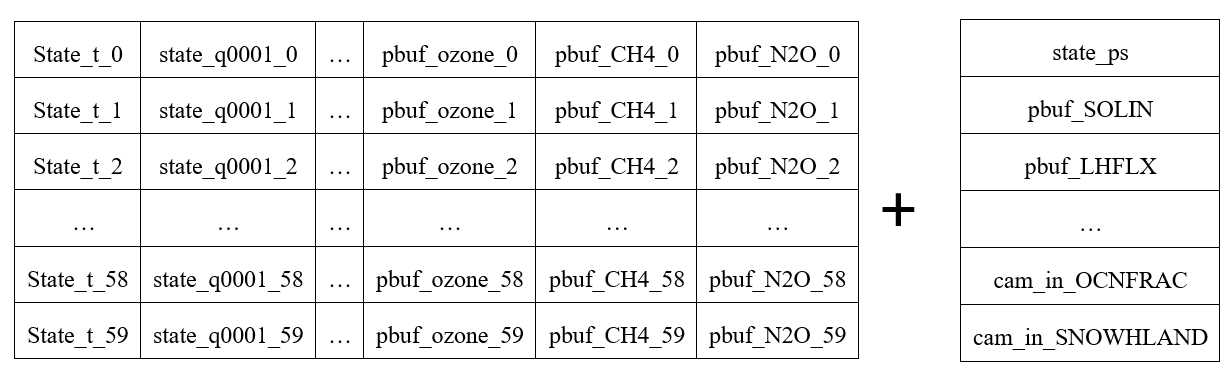  

<!-- <font color='red'>Un-comment images to see</font> -->

This is what input data look like

---

After test, the input has (16,1) and (9, 60), the output has (8,1) and (6, 60)

In [8]:
import re

# 转换数据集
def convert_data(cols, line):
    # 输入一个表头和一行的数据，将其转换为两个张量
    tensor1d = [[],[]]
    tensor2d = [[],[]]
    old_title = ''
    for col, value in zip(cols, line):
        match = re.search(r'_(\d+)$', col)
        if match is None: # in 1d tensor
            tensor1d[0].append(col)
            tensor1d[1].append([value])
        else:
            title = col[:-len(match.group(0))]
            if not title == old_title:
                old_title = title
                tensor2d[0].append(title)
                tensor2d[1].append([])
            tensor2d[1][-1].append(value)
    tensor1d[0] = np.array(tensor1d[0])
    tensor2d[0] = np.array(tensor2d[0])
    tensor1d[1] = np.array(tensor1d[1])
    tensor2d[1] = np.array(tensor2d[1])
    return tensor1d, tensor2d
        
# d1, d2 = convert_data(val_out.columns, val_out.iloc[0]) # 测试一行
# print(f'{d1[0].shape = }\t{d1[0].dtype = }')
# print(f'{d1[1].shape = }\t{d1[1].dtype = }')
# print(f'{d2[0].shape = }\t{d2[0].dtype = }')
# print(f'{d2[1].shape = }\t{d2[1].dtype = }')

# Dataset

Define a custom dataset for this input/output

In [9]:
class MyDataset(Dataset):
    def __init__(self, dsin, dsout, transform=transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.dsout = dsout
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, x):
        in1, in2 = convert_data(self.dsin.columns, self.dsin.iloc[x])
#         out1, out2 = convert_data(self.dsout.columns, self.dsout.iloc[x])
        din = [in1[1], in2[1]]
#         dout = [out1[1], out2[1]]
        dout = np.array([[value] for value in self.dsout.iloc[x]])
#         print(f'{dout.shape = }')
        
        if self.transform:
            din[0] = self.transform(din[0])
            din[1] = self.transform(din[1])
#             dout[0] = self.transform(dout[0])
#             dout[1] = self.transform(dout[1])
            dout = self.transform(dout)
        
        # 使用torch.unsqueeze将数组从[m, n]转换为[1, m, n]
#         din = [torch.from_numpy(tensor) for tensor in din]
#         dout = [torch.from_numpy(tensor) for tensor in dout]
        din = [tensor.to(torch.float32) for tensor in din]
#         dout = [tensor.to(torch.float32)  for tensor in dout]
        dout = dout.to(torch.float32)
        
        return din, dout

In [10]:
batch_size = 200
num_workers = 128
lr = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_dataset = MyDataset(train_in, train_out)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(train_dataset) = }')

val_dataset = MyDataset(val_in, val_out)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
print(f'{len(val_dataset) = }')

train_dataset[0][1].size()

In [ ]:
# val_dataset[0]

# Build model

Model structure is like this

<!-- 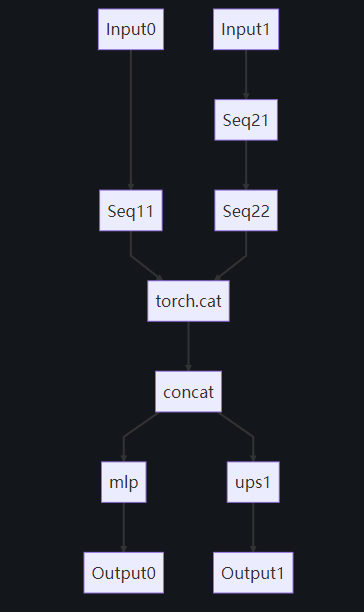 -->
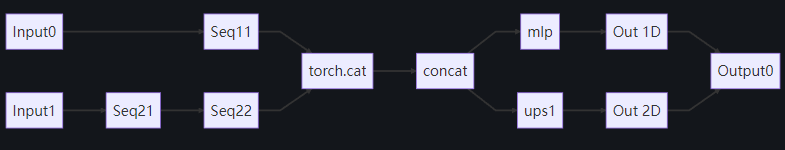

```mermaid
graph LR

A[Input0] ---> B[Seq11] --> C[torch.cat]
D[Input1] --> E[Seq21] --> F[Seq22] --> C
C --> G[concat] --> H[mlp] --> I[Out 1D] --> Z[Output0]
G --> J[ups1] --> K[Out 2D] --> Z
```

Compared with the old version which didn't merge the 2 outputs, the new model is better for MSELoss and $R^2$ for calculating accuracies.

And the new model can train more quickly than the old one


In [11]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    if type(kernel_size) != tuple:
        factor = (kernel_size + 1) // 2
        if kernel_size % 2 == 1:
            center = factor - 1
        else:
            center = factor - 0.5
        og = (torch.arange(kernel_size[0]).reshape(-1, 1),
              torch.arange(kernel_size[1]).reshape(1, -1))
        filt = (1 - torch.abs(og[0] - center) / factor) * \
               (1 - torch.abs(og[1] - center) / factor)
        weight = torch.zeros((in_channels, out_channels,
                              kernel_size, kernel_size))
        weight[range(in_channels), range(out_channels), :, :] = filt
    else:
        factor1 = (kernel_size[0] + 1) // 2
        factor2 = (kernel_size[1] + 1) // 2
        if kernel_size[0] % 2 == 1:
            center1 = factor1 - 1
        else:
            center1 = factor1 - 0.5
        if kernel_size[1] % 2 == 1:
            center2 = factor2 - 1
        else:
            center2 = factor2 - 0.5
        og = (torch.arange(kernel_size[0]).reshape(-1, 1),
              torch.arange(kernel_size[1]).reshape(1, -1))
        filt = (1 - torch.abs(og[0] - center1) / factor1) * \
               (1 - torch.abs(og[1] - center2) / factor2)
        weight = torch.zeros((in_channels, out_channels,
                              kernel_size[0], kernel_size[1]))
        weight[range(in_channels), range(out_channels), :, :] = filt
    return weight

class TransConv(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, 
                 kernel_size, stride=1, padding=0):
        super(TransConv, self).__init__()
        self.trans_conv = nn.ConvTranspose2d(in_channels, out_channels, 
                 kernel_size, stride, padding)
        self.trans_conv.weight.data.copy_(bilinear_kernel(in_channels, out_channels, kernel_size))
        
    def forward(self, x):
        return self.trans_conv(x)
    
    
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        self.flatten = nn.Flatten()
        
    def forward(self, x):
        out1d = x[0]
        out2d = x[1]
        out1d = out1d.flatten(1)
        out2d = out2d.flatten(1)
        out = torch.cat((out2d, out1d), 1)
        out = torch.unsqueeze(out, 1)
        out = torch.unsqueeze(out, 3)
        return out
        
        

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.seq11 = nn.Sequential( # 1, 16, 1
            nn.Conv2d(1, 16, 3, padding=(1, 2)), # 16, 16, 3
            nn.Conv2d(16, 32, 5, padding=(2, 3)), # 32, 16, 5
            nn.MaxPool2d((2,1)), # 32, 8, 5
            nn.ReLU(),
            nn.Conv2d(32, 64, 5, padding=(2, 4)),
            nn.MaxPool2d(2), 
            nn.ReLU(),
        ) # 64, 4, 4
        
        self.seq21 = nn.Sequential( # 1, 9, 60
            nn.Conv2d(1, 8, 5, padding=3),
            nn.Conv2d(8, 16, 5, padding=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, padding=3),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        ) # 64, 2, 8
        self.seq22 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=(2,3)),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, padding=(2,2)),
            nn.MaxPool2d((1,2)),
            nn.ReLU()
        ) # 256, 4, 4
        
        self.concat = nn.Sequential(
            nn.Conv2d(320, 320, 5, padding=4),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.ups1 = nn.Sequential(
            nn.Conv2d(320, 1, 1),
            TransConv(1, 1, (32, 64), padding=(25,8), stride=(8,4)),
        )
        
        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(144),
            nn.LazyLinear(84),
            nn.LazyLinear(8),
        )
        
        self.flatten = Flatten()
        
    
    def forward(self, x):
        t1d, t2d = x[0], x[1]
        t1d = self.seq11(t1d)
        t2d = self.seq21(t2d)
        t2d = self.seq22(t2d)
        tsr = torch.cat([t1d,t2d], 1)
        tsr = self.concat(tsr)
        out1 = self.mlp(tsr)
        out1 = torch.unsqueeze(out1, 1)  # 添加一个额外的维度
        out1 = torch.unsqueeze(out1, 3)  # 添加另一个额外的维度
        out2 = self.ups1(tsr)
        out = (out1, out2)   
        out = self.flatten(out)
        return out
    


In [12]:
net = Net().to(device)
weights = torch.load('/kaggle/input/atmospred/pytorch/trained.pth/1/20240502-001.pth', map_location=device)
net.load_state_dict(weights)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [13]:
ttensor = [torch.rand(2, 1, 8, 1), torch.rand(2, 1, 6, 60)]
net.flatten(ttensor).shape

torch.Size([2, 1, 368, 1])

In [14]:
import torch.optim as optim

# def criterion(pred, target):
#     loss1 = torch.mean((pred[0] - target[0])**2)
#     loss2 = torch.mean((pred[1] - target[1])**2)
#     loss = loss1 + loss2
#     return loss

criterion = nn.MSELoss()
    
optimizer = optim.Adam(net.parameters(), lr=lr)

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

def graph(acc, loss, title):
    """ 绘制准确率和损失曲线

    Args:
        acc (list): [train, val]/[test]
        loss (list): [train, val]/[test]
        title (str): Title
    """
    assert len(acc) == len(loss), 'Length of acc and loss must be the same'
    global save_run_dir
    if len(acc) == 2:
        plt.subplot(1, 2, 1)
        plt.plot(acc[0], label='Training Accuracy')
        plt.plot(acc[1], label='Validation Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(loss[0], label='Training Loss')
        plt.plot(loss[1], label='Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    elif len(acc) == 1:
        plt.subplot(2, 1, 1)
        plt.plot(acc[0], label='Test Accuracy')
        plt.title(title)
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
        plt.subplot(2, 1, 2)
        plt.plot(loss[0], label='Test Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
    plt.show()

In [16]:
def r2accu(pred, targ):
    residual_err = pred - targ
    err_sq = residual_err ** 2
    ss_res = torch.sum(err_sq)
    ss_tot = torch.sum(pred ** 2 + targ ** 2)
    r_2 = 1 - (ss_res / ss_tot)
    return r_2.item()

ts1, ts2 = torch.tensor((1,2,3,4)), torch.tensor((2,2,3,4))
ts1, ts2, r2accu(ts1, ts2)

(tensor([1, 2, 3, 4]), tensor([2, 2, 3, 4]), 0.9841269850730896)

In [17]:
num_epochs = 5

# ----------------------

lowest_loss = float('inf')

accus, losses = [[],[]], [[],[]]

In [ ]:
timer.start(f'Train {num_epochs} epochs')
for epoch in range(num_epochs):
    t0 = time.time()
    net.train()
    train_loss = 0.0
    train_accu = 0.0
    num_train_batches = 0

    for inp, outp in tqdm(train_loader):
        inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.to(device)
        out_h = net(inp)
        crit = criterion(out_h, outp)
        loss = crit.item()
        train_loss += loss
        accu = r2accu(out_h, outp)
        train_accu += accu
        crit.backward()
        optimizer.step()
        optimizer.zero_grad()
        num_train_batches += 1
    avg_train_loss = train_loss / num_train_batches
    losses[0].append(avg_train_loss)
    avg_train_accu = train_accu / num_train_batches
    accus[0].append(avg_train_accu)

    net.eval()
    val_loss = 0.0
    val_accu = 0.0
    num_val_batches = 0

    with torch.no_grad():
        for inp, outp in tqdm(val_loader):
            inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.to(device)
            out_h = net(inp)
            crit = criterion(out_h, outp)
            val_loss += crit.item()
            accu = r2accu(out_h, outp)
            val_accu += accu
            num_val_batches += 1

    avg_val_loss = val_loss / num_val_batches
    losses[1].append(avg_val_loss)
    avg_val_accu = val_accu / num_val_batches
    accus[1].append(avg_val_accu)
    
    if avg_val_loss < lowest_loss:
        torch.save(net.state_dict(), 'best.pth')  # 保存模型参数而不是整个模型
        lowest_loss = avg_val_loss

    t1 = time.time()
    print(f'Epoch {epoch} > Time Cost: {t1-t0:.2f}s \n\t', 
          f'Train Loss: {avg_train_loss:.3f} | Val Loss: {avg_val_loss:.3f}\n\t',
          f'Train Accu: {avg_train_accu:.3f} | Val Accu: {avg_val_accu:.3f}')

timer.stop()
graph(accus, losses, 'Train')

In [ ]:
torch.save(net.state_dict(), "latest.pth") 

# Test Model

In [64]:
try:
    del(net)
    print('Trained net released!')
except:
    print('No model trained')

No model trained


In [65]:
net = Net()
# net.load_state_dict(torch.load('/kaggle/input/atmospred/pytorch/trained.pth/1/20240502-001.pth', map_location=device))
# net.load_state_dict(torch.load('best.pth', map_location=device))

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


<All keys matched successfully>

In [ ]:
test_dataset = MyDataset(test_in, test_out)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
print(f'{len(test_dataset) = }')

In [ ]:
timer.start()
net.eval()
test_loss = 0.0
test_accu = 0.0
num_test_batches = 0

with torch.no_grad():
    for i, (inp, outp) in enumerate(tqdm(test_loader)):
        inp, outp = [inps.to(device, non_blocking=True) for inps in inp], outp.to(device)
        out_h = net(inp)
        crit = criterion(out_h, outp)
        test_loss += crit.item()
        test_accu += r2accu(out_h, outp)
        num_test_batches += 1

avg_test_loss = test_loss / num_test_batches
avg_test_accu = test_accu / num_test_batches

print(f'Test Loss: {avg_test_loss:.3f} | Test Accu: {avg_test_accu:.3f}')
timer.stop()

# Read test input data

I didn't learn about Polars, but i heard it faster than pandas. So in this part I want to try polars instead of pandas. 

If everything goes well, i may switch the former pandas operations to polars. 

In [18]:
import polars as pl

timer.start()
subm_set = pl.read_csv(test_csv)
subm_multip = pl.read_csv(subm_spl)
timer.stop()

0 Run Time Cost: 25.544s


In [19]:
subm_multip.head(2)

sample_id,ptend_t_0,ptend_t_1,ptend_t_2,ptend_t_3,ptend_t_4,ptend_t_5,ptend_t_6,ptend_t_7,ptend_t_8,ptend_t_9,ptend_t_10,ptend_t_11,ptend_t_12,ptend_t_13,ptend_t_14,ptend_t_15,ptend_t_16,ptend_t_17,ptend_t_18,ptend_t_19,ptend_t_20,ptend_t_21,ptend_t_22,ptend_t_23,ptend_t_24,ptend_t_25,ptend_t_26,ptend_t_27,ptend_t_28,ptend_t_29,ptend_t_30,ptend_t_31,ptend_t_32,ptend_t_33,ptend_t_34,ptend_t_35,…,ptend_v_31,ptend_v_32,ptend_v_33,ptend_v_34,ptend_v_35,ptend_v_36,ptend_v_37,ptend_v_38,ptend_v_39,ptend_v_40,ptend_v_41,ptend_v_42,ptend_v_43,ptend_v_44,ptend_v_45,ptend_v_46,ptend_v_47,ptend_v_48,ptend_v_49,ptend_v_50,ptend_v_51,ptend_v_52,ptend_v_53,ptend_v_54,ptend_v_55,ptend_v_56,ptend_v_57,ptend_v_58,ptend_v_59,cam_out_NETSW,cam_out_FLWDS,cam_out_PRECSC,cam_out_PRECC,cam_out_SOLS,cam_out_SOLL,cam_out_SOLSD,cam_out_SOLLD
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""test_169651""",30981.265272,22502.432414,18894.14713,14514.244731,10944.348069,9065.01072,9663.669039,12688.557363,19890.172265,25831.373172,33890.367562,44122.94111,59811.255951,79434.075001,107358.809169,135720.841835,149399.841111,128492.951853,91746.236873,72748.769111,66531.535968,62932.305984,56610.268743,49473.143692,43029.184954,36912.674919,31486.931179,26898.072997,23316.638283,20459.731332,18385.683096,17111.405108,16337.80992,15857.759882,15580.902485,15497.59046,…,122460.653992,132086.693875,141041.48571,146354.094413,145953.095901,139496.800789,128508.851082,116665.517697,107458.397063,100259.972367,94108.98505,88439.894562,82734.902766,77061.086214,71333.531924,65999.725321,61798.997206,58237.35642,54715.102663,50825.844317,46059.176887,40740.260504,36335.802283,33981.575686,33589.714339,33988.885241,36272.936451,41183.344137,29194.123693,0.004054,0.013882,1.3513e8,1.2220e7,0.009071,0.00859,0.021537,0.033632
"""test_524862""",30981.265272,22502.432414,18894.14713,14514.244731,10944.348069,9065.01072,9663.669039,12688.557363,19890.172265,25831.373172,33890.367562,44122.94111,59811.255951,79434.075001,107358.809169,135720.841835,149399.841111,128492.951853,91746.236873,72748.769111,66531.535968,62932.305984,56610.268743,49473.143692,43029.184954,36912.674919,31486.931179,26898.072997,23316.638283,20459.731332,18385.683096,17111.405108,16337.80992,15857.759882,15580.902485,15497.59046,…,122460.653992,132086.693875,141041.48571,146354.094413,145953.095901,139496.800789,128508.851082,116665.517697,107458.397063,100259.972367,94108.98505,88439.894562,82734.902766,77061.086214,71333.531924,65999.725321,61798.997206,58237.35642,54715.102663,50825.844317,46059.176887,40740.260504,36335.802283,33981.575686,33589.714339,33988.885241,36272.936451,41183.344137,29194.123693,0.004054,0.013882,1.3513e8,1.2220e7,0.009071,0.00859,0.021537,0.033632


In [20]:
insts = subm_set[subm_set.columns[0]]
subm_in = subm_set[subm_set.columns[1:]]
subm_in.shape

(625000, 556)

In [21]:
class TestDataset(Dataset):
    def __init__(self, dsin, transform=transforms.Compose([
        transforms.ToTensor(),
    ])):
        self.dsin = dsin
        self.transform =transform
    
    def __len__(self):
        return self.dsin.shape[0]
    
    def __getitem__(self, x):
        in1, in2 = convert_data(self.dsin.columns, self.dsin.row(x))
        din = [in1[1], in2[1]]
        
        if self.transform:
            din[0] = self.transform(din[0])
            din[1] = self.transform(din[1])
        
        # 使用torch.unsqueeze将数组从[m, n]转换为[1, m, n]
#         din = [torch.from_numpy(tensor) for tensor in din]
        din = [tensor.to(torch.float32) for tensor in din]
        
        return din

In [22]:
subm_dataset = TestDataset(subm_in)
subm_dataset[0][0].shape, subm_dataset[0][1].shape

(torch.Size([1, 16, 1]), torch.Size([1, 9, 60]))

# Process the output

- write a function to multiply predictions with sample data
- save file

In [23]:
# out_df = subm_multip[subm_multip.columns[1:]]
subm_multip = subm_multip.to_numpy()
subm_multip.shape, subm_multip[:, 0]

((625000, 369),
 array(['test_169651', 'test_524862', 'test_634129', ..., 'test_88942',
        'test_79382', 'test_601350'], dtype=object))

In [24]:
out_df = subm_multip[:, 1:].astype(float)
out_df = torch.tensor(out_df).to(device).to(torch.float32)
out_df.shape, out_df[1:4, 2:4]

(torch.Size([625000, 368]),
 tensor([[18894.1465, 14514.2451],
         [18894.1465, 14514.2451],
         [18894.1465, 14514.2451]], device='cuda:0'))

In [25]:
def convert_output(pred):
    """将输出张量转换为 dataframe 的 n 行"""
    pred = pred.squeeze(3).squeeze(1)
    return pred

def postprocess(pred, scaler):
    pred = convert_output(pred)
    scaler *= pred
    return scaler

In [26]:
subm_batch_size = batch_size

In [27]:
subm_loader = DataLoader(subm_dataset, batch_size = subm_batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
result = None
data_len = len(subm_loader)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 128 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
timer.start()
with torch.no_grad():
    for i, smp in enumerate(subm_loader):
        smp =  [smps.to(device, non_blocking=True) for smps in smp]
        scaler = out_df[i*subm_batch_size:(i+1)*subm_batch_size, :]
        pred = net(smp)
        scaler = postprocess(pred, scaler)
        if i == 0:
            result = scaler
        else:
            result = torch.cat((result, scaler), axis=0)
        print(f'[{"=" * int(25 * i / data_len)}{"C" if i % 2 == 0 else "c"}{"-" * (25 - int(25 * i / data_len))}] Batch {i}/{data_len} > {result.shape = } | \r', end='')

print(f'Batch {i} > {result.shape = } | ')
timer.stop()